<a href="https://colab.research.google.com/github/projectsforstudents2022/Bitcoin_Price_Prediction/blob/main/Bitcoin_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Load libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [4]:
# Mount Drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Load the dataset

data = pd.read_csv("/content/drive/MyDrive/Projects/Bitcoin_Price_Prediction/bitcoin_ticker.csv")
data.head()

,date_id,datetime_id,market,rpt_key,last,diff_24h,diff_per_24h,bid,ask,low,high,volume,created_at,updated_at
0,2017-05-31,2017-06-01 00:00:00,bitstamp,btc_eur,1996.72,2029.99,-1.638924,2005.50,2005.56,1950.00,2063.73,2314.500750,2017-05-31 14:59:36,2017-05-31 14:59:36
1,2017-05-31,2017-06-01 00:00:00,bitflyer,btc_jpy,267098.00,269649.00,-0.946045,267124.00,267267.00,267124.00,267267.00,70922.880112,2017-05-31 14:59:36,2017-05-31 14:59:36
2,2017-05-31,2017-06-01 00:00:00,korbit,btc_krw,3003500.00,3140000.00,-4.347134,3003500.00,3004000.00,3002000.00,3209500.00,6109.752872,2017-05-31 14:59:36,2017-05-31 14:59:36
3,2017-05-31,2017-06-01 00:00:00,bitstamp,btc_usd,2237.40,2239.37,-0.087971,2233.09,2237.40,2154.28,2293.46,13681.282017,2017-05-31 14:59:36,2017-05-31 14:59:36
4,2017-05-31,2017-06-01 00:00:00,okcoin,btc_usd,2318.82,2228.70,4.043613,2319.40,2319.99,2129.78,2318.82,4241.641516,2017-05-31 14:59:36,2017-05-31 14:59:36


In [6]:
data['rpt_key'].value_counts()

btc_usd       125438
btc_eur        62719
btc_jpy        62719
btc_krw        62719
etc_krw        62719
eth_btc        62719
eth_krw        62719
fx_btc_jpy     62719
ltc_usd        62719
Name: rpt_key, dtype: int64

In [7]:
# Subset USD

df = data.loc[(data['rpt_key'] == 'btc_usd')]
df.head()

,date_id,datetime_id,market,rpt_key,last,diff_24h,diff_per_24h,bid,ask,low,high,volume,created_at,updated_at
3,2017-05-31,2017-06-01 00:00:00,bitstamp,btc_usd,2237.40,2239.37,-0.087971,2233.09,2237.40,2154.28,2293.46,13681.282017,2017-05-31 14:59:36,2017-05-31 14:59:36
4,2017-05-31,2017-06-01 00:00:00,okcoin,btc_usd,2318.82,2228.70,4.043613,2319.40,2319.99,2129.78,2318.82,4241.641516,2017-05-31 14:59:36,2017-05-31 14:59:36
15,2017-06-01,2017-06-01 00:01:00,bitstamp,btc_usd,2248.39,2242.44,0.265336,2247.77,2248.38,2154.28,2293.46,13701.698603,2017-05-31 15:00:36,2017-05-31 15:00:36
16,2017-06-01,2017-06-01 00:01:00,okcoin,btc_usd,2320.42,2228.40,4.129420,2320.99,2321.49,2129.78,2322.00,4260.261516,2017-05-31 15:00:36,2017-05-31 15:00:36
23,2017-06-01,2017-06-01 00:02:00,bitstamp,btc_usd,2248.35,2238.58,0.436437,2248.35,2248.69,2154.28,2293.46,13742.110913,2017-05-31 15:01:36,2017-05-31 15:01:36


In [8]:
# Convert Datetime_id To Datatype

df = df.reset_index(drop=True)
df['datetime'] = pd.to_datetime(df['datetime_id'])
df = df.loc[df['datetime'] > pd.to_datetime('2017-06-28 00:00:00')]
df = df[['datetime', 'last', 'diff_24h', 'diff_per_24h', 'bid', 'ask', 'low', 'high', 'volume']]
df.head()

,datetime,last,diff_24h,diff_per_24h,bid,ask,low,high,volume
77762,2017-06-28 00:01:00,2344.00,2491.98,-5.938250,2335.01,2343.89,2307.0,2473.19,20719.583592
77763,2017-06-28 00:01:00,2499.39,2682.25,-6.817411,2495.00,2499.33,2444.0,2780.62,2265.557866
77764,2017-06-28 00:02:00,2337.18,2491.98,-6.211928,2337.18,2340.00,2307.0,2473.19,20732.082581
77765,2017-06-28 00:02:00,2492.76,2682.25,-7.064591,2492.76,2495.00,2444.0,2780.62,2262.618866
77766,2017-06-28 00:03:00,2335.02,2491.98,-6.298606,2335.01,2335.02,2307.0,2473.19,20665.357191


In [9]:
df = df[['last']]
dataset = df.values
dataset = dataset.astype('float32')
dataset

array([[2344.  ],
       [2499.39],
       [2337.18],
       ...,
       [2394.03],
       [2320.47],
       [2394.03]], dtype=float32)

In [10]:
# Buld Min Max Scaler

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
dataset

array([[0.1997695 ],
       [0.49828053],
       [0.18666792],
       ...,
       [0.29587936],
       [0.15456724],
       [0.29587936]], dtype=float32)

In [11]:
# Train Test Split

train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print(len(train), len(test))

31942 15734


In [12]:
# convert an array of values into a dataset matrix

def create_dataset(dataset, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back, 0])
  return np.array(dataX), np.array(dataY)

In [13]:
look_back = 10
trainX, trainY = create_dataset(train, look_back=look_back)
testX, testY = create_dataset(test, look_back=look_back)

In [14]:
# reshape input to be [samples, time steps, features]

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [15]:
# Build our Model

model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=256, verbose=2)

Epoch 1/100
125/125 - 3s - loss: 0.0778 - 3s/epoch - 22ms/step
Epoch 2/100
125/125 - 0s - loss: 0.0089 - 254ms/epoch - 2ms/step
Epoch 3/100
125/125 - 0s - loss: 0.0070 - 257ms/epoch - 2ms/step
Epoch 4/100
125/125 - 0s - loss: 0.0050 - 261ms/epoch - 2ms/step
Epoch 5/100
125/125 - 0s - loss: 0.0031 - 243ms/epoch - 2ms/step
Epoch 6/100
125/125 - 0s - loss: 0.0017 - 250ms/epoch - 2ms/step
Epoch 7/100
125/125 - 0s - loss: 7.7743e-04 - 281ms/epoch - 2ms/step
Epoch 8/100
125/125 - 0s - loss: 3.3160e-04 - 246ms/epoch - 2ms/step
Epoch 9/100
125/125 - 0s - loss: 1.7517e-04 - 259ms/epoch - 2ms/step
Epoch 10/100
125/125 - 0s - loss: 1.3331e-04 - 246ms/epoch - 2ms/step
Epoch 11/100
125/125 - 0s - loss: 1.2248e-04 - 262ms/epoch - 2ms/step
Epoch 12/100
125/125 - 0s - loss: 1.1863e-04 - 252ms/epoch - 2ms/step
Epoch 13/100
125/125 - 0s - loss: 1.1671e-04 - 244ms/epoch - 2ms/step
Epoch 14/100
125/125 - 0s - loss: 1.1562e-04 - 268ms/epoch - 2ms/step
Epoch 15/100
125/125 - 0s - loss: 1.1497e-04 - 258ms/ep

In [16]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [17]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [18]:

trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:, 0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:, 0]))
print('Test Score: %.2f RMSE' % (testScore))


Train Score: 4.72 RMSE
Test Score: 5.99 RMSE


In [20]:
# shift train predictions for plotting

trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict) + look_back, :] = trainPredict

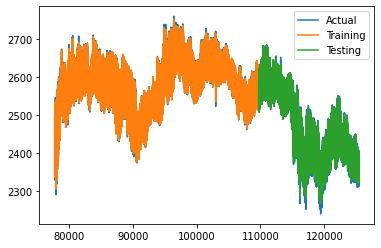

In [21]:
 # shift test predictions for plotting

testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + (look_back * 2) + 1:len(dataset) - 1, :] = testPredict
 plt.plot(df['last'], label='Actual')
plt.plot(pd.DataFrame(trainPredictPlot, columns=["close"], index=df.index).close, label='Training')
plt.plot(pd.DataFrame(testPredictPlot, columns=["close"], index=df.index).close, label='Testing')
plt.legend(loc='best')
plt.show()